In [1]:
from sympy import *#symbols,functions,Derivative,Function, Piecewise , Eq, integrate,dsolve
from functools import  partial,reduce
from itertools import repeat
import numpy as np
import scipy as sp
import pprint  as pp
import matplotlib.pyplot as plt
import math
from ipywidgets import interact,widgets

In [3]:
a,b1,b2,c,d,t= symbols('a b1 b2 c d t')

p_Ts , p_TM, p_T = symbols ('p_Ts p_TM p_T')
p_Csa , p_QM , p_Rs , p_DVo = symbols('p_Csa p_QM p_Rs p_DVo')

f, f_TM, f_Ts, f_T =symbols('f f_TM f_Ts f_T',cls=Function)

f_Qao =  Piecewise( (b1 * t        , And(0<t,t<p_TM) ) , 
                    (b2 * (d-t)   , And(p_TM<t,t<p_Ts) ) , 
                    (0          , True #And(p_Ts<t,t<p_T )
                    ) )

#f_Psa_TM = Eq(a*f(t).diff(t) ,  b1 * t-c*f(t) )
#f_Psa_Ts = Eq(a*f(t).diff(t) ,  b2 * (d-t)-c*f(t) )
#f_Psa_T  = Eq(a*f(t).diff(t) ,  -c * f(t) )
#
#f_PSA_pw = Piecewise(   (f_Psa_TM, And(0<t,t<p_TM) ) , 
#                        (f_Psa_Ts, And(p_TM<t,t<p_Ts) ) , 
#                        (f_Psa_T, And(p_Ts<t,t<p_T )) )


#f_Aux = - c*f(t)/a
#f_Psa = Eq(a*f(t).diff(t),- c*f(t))

In [57]:
#subs
subDict_pmt = { a  : p_Csa , 
            b1 : p_QM/p_TM  , 
            b2 : p_QM/(p_Ts- p_TM) , 
            c  : 1/p_Rs , 
            d  : p_Ts , 

            #'C1' : p_DVo/(p_Csa*(1-exp(-p_T/(p_Rs*p_Csa)))) 
            }

subDict_val = {  
    p_T     :   0.0125,
    p_Ts    :   0.005,
    p_TM    :   0.002,
    p_Csa   :   0.00175,
    p_Rs    :   17.5,
    p_QM    :   28 ,
    p_DVo   :   0.07,
    #t       :   t%0.0125
}

solvDict = { 
            'B' : 'BDF'  ,
            'R' : 'Radau',
            'L' : 'LSODA',
            'D' : 'DOP853'
}

In [58]:
lf_Qao = lambdify([t] , f_Qao.subs(subDict_pmt).subs(subDict_val))
pval = lambda p : subDict_val[p]

ff_Qao = lambda t : lf_Qao(t)

f_Psa  = lambda t, Psa : ff_Qao(t)/pval(p_Csa) - Psa/(pval(p_Csa) * pval(p_Rs))

ff_Psa = lambda t, Psa : f_Psa( (t%subDict_val[p_T]) , Psa )

In [59]:
sol = sp.integrate.solve_ivp(ff_Psa , (0,1) , [1] , method='LSODA' ) 
sol.y

array([[  1.        ,   1.00096862,   1.00333738, ..., 102.68374242,
         87.27523316,  85.69891137]])

In [60]:
f_Qao.subs(subDict_pmt)

Piecewise((p_QM*t/p_TM, (p_TM > t) & (t > 0)), (p_QM*(p_Ts - t)/(-p_TM + p_Ts), (p_Ts > t) & (p_TM < t)), (0, True))

### Probando $Q_{A_o}$
Solo graficamos un ciclo porque para el comportamiento cíclico usaremos el operador módulo en la función para $P_{sa}$, previamente ya se había sacado el dibujo de 3 ciclos de esta función.

[(0.0, array(0.)), (5.0251256281407036e-05, array(0.70351759)), (0.00010050251256281407, array(1.40703518)), (0.00015075376884422112, array(2.11055276)), (0.00020100502512562814, array(2.81407035)), (0.0002512562814070352, array(3.51758794)), (0.00030150753768844223, array(4.22110553)), (0.00035175879396984926, array(4.92462312)), (0.0004020100502512563, array(5.6281407)), (0.0004522613065326633, array(6.33165829)), (0.0005025125628140704, array(7.03517588)), (0.0005527638190954774, array(7.73869347)), (0.0006030150753768845, array(8.44221106)), (0.0006532663316582914, array(9.14572864)), (0.0007035175879396985, array(9.84924623)), (0.0007537688442211055, array(10.55276382)), (0.0008040201005025126, array(11.25628141)), (0.0008542713567839197, array(11.95979899)), (0.0009045226130653266, array(12.66331658)), (0.0009547738693467337, array(13.36683417)), (0.0010050251256281408, array(14.07035176)), (0.0010552763819095478, array(14.77386935)), (0.0011055276381909548, array(15.47738693)), 

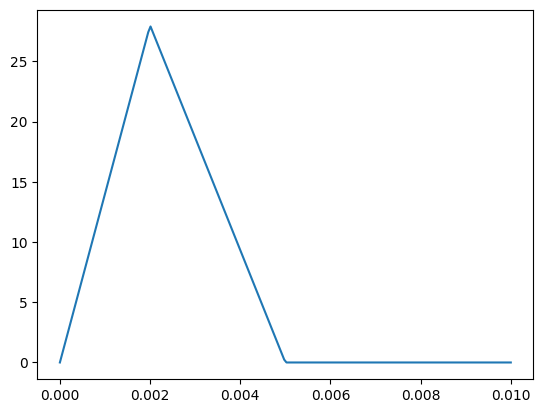

In [61]:
ls = np.linspace(0,0.01,200)
plt.plot(ls, 
list(map(ff_Qao,ls))
)
print(data)

### Probando $P_{sa}$

para ver como funciona usamos un widget y luego sacamos una única gráfica con varias lineas comparando los cambios para diferentes valores iniciales

In [103]:

@interact(      iv_Psa   =   (  -20   , 500  ,  1 ), 
                span_M   =   (  0   , 0.15   ,  0.001) 
                )
def plotFunc( iv_Psa , span_M=0.05, save = False):
    
    span_t = ( min(0,span_M) , max(0,span_M) )
    
    sol = sp.integrate.solve_ivp(ff_Psa , span_t , [iv_Psa] , 
            dense_output=True ,
            max_step=250e-6,
            method=solvDict['R'] #B R D L
            ) 

    #V vs t
    print(len(sol.y[0]))
    #fig0 = plt.subplot(111)
    plt.plot(sol.t,sol.y[0])
    plt.legend(["V"],loc=1)
    #plt.tick_params(labelbottom=False)
    #fig0.set_ybound(-100,40)
    #fig0.set_ylabel("Voltaje [mV]")
    
    plt.grid(visible=True)    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig( "dibujitos I={Ix:.2f}.png".format(Ix=Ix))  if save else _
    plt.show()


interactive(children=(IntSlider(value=240, description='iv_Psa', max=500, min=-20), FloatSlider(value=0.05, de…

In [186]:
ivl_psa =[[x] for x in np.linspace(-25,250,15)]

f_ivp = partial(sp.integrate.solve_ivp,
            fun=ff_Psa,
            t_span=(0,0.06),
            dense_output=True ,
            max_step=250e-6,
            method=solvDict['R'] #B R D L
            )
            

sols = list(map( lambda iv : f_ivp(y0=iv) , ivl_psa ))



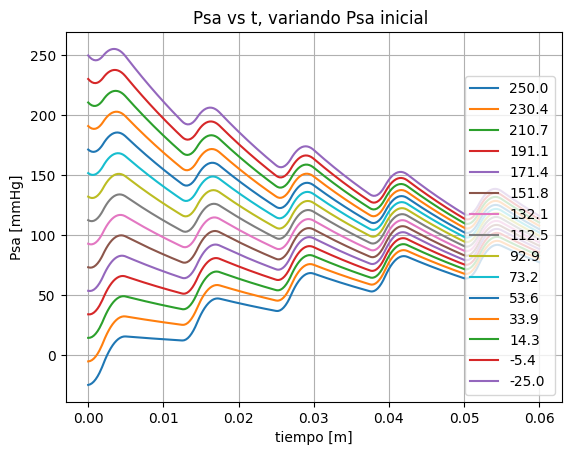

In [189]:
def plotterAux(sol):
    return plt.plot(sol.t,sol.y[0])

#plt.subplot(121)
plots = [plotterAux(sol) for sol in sols]
legends = list( map(lambda s : "{iv:3.1f}".format(iv=s[0]) , ivl_psa[-1::-1]) )
plt.legend( legends ,loc=4 )
plt.ylabel("Psa [mmHg]")
plt.xlabel("tiempo [m]")
plt.title("Psa vs t, variando Psa inicial ")
plt.grid(visible=True)
plt.savefig("fig_iv_Psa.jpg")



In [143]:
for p in plots:
    plt.show(p)


In [138]:
test = partial(sp.integrate.solve_ivp,
            fun=ff_Psa,
            t_span=(0,0.05),
            dense_output=True ,
            max_step=250e-6,
            method=solvDict['R'] #B R D L
            )

sol=test(y0=[10] )
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.500e-04 ...  4.986e-02  5.000e-02]
        y: [[ 1.000e+01  1.017e+01 ...  7.123e+01  7.090e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001AC46183E50>
 t_events: None
 y_events: None
     nfev: 1415
     njev: 1
      nlu: 396